In [1]:
import numpy as np
import time
import pickle
import utils as Utils
import pandas as pd
import random
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
# import modules.model as Model
from matplotlib.backends.backend_pdf import PdfPages
import sklearn.metrics as metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score,classification_report,roc_curve,auc, f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE 
# import modules.processor as Processor
# import modules.utils as Utils
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from tqdm import tqdm
import processor as Processor

In [2]:
# !pip3 install xgboost

In [3]:
train_trb = pd.read_csv("./data_final/train_trb.csv")
test_trb = pd.read_csv("./data_final/test_trb.csv")

In [4]:
train_trb_case1_rf_20 = pd.read_csv("./data_final/train_trb_case1_rf_20.csv",)
test_trb_case1_cb_60  = pd.read_csv("./data_final/test_trb_case1_cb_60.csv", )
train_trb_case2_rf_20 = pd.read_csv("./data_final/train_trb_case2_rf_20.csv",)
test_trb_case2_cb_60  = pd.read_csv("./data_final/test_trb_case2_cb_60.csv", )
train_trb_case3_rf_20 = pd.read_csv("./data_final/train_trb_case3_rf_20.csv",)
test_trb_case3_cb_60  = pd.read_csv("./data_final/test_trb_case3_cb_60.csv", )

In [5]:
test_paper_case1_exc_epi = pd.read_csv("./data_final/test_paper_case3_exc_epi.csv")

# Case 03

In [6]:
nm = RandomUnderSampler(random_state=42)
X_res_case1, y_res_case1 = nm.fit_resample(train_trb_case3_rf_20[["CDR3b", "epitope"]], train_trb_case3_rf_20[["binder"]])

In [7]:
X_res_case1.shape, y_res_case1.shape

((120670, 2), (120670, 1))

In [8]:
pX_res_case1 = Processor.data_representation_blosum62(X_res_case1)
py_res_case1 = y_res_case1.copy()

pX_test_rf_case1 = Processor.data_representation_blosum62(test_trb_case3_cb_60)
py_test_rf_case1 = test_trb_case3_cb_60[["binder"]]

pX_test_cb_case1 = Processor.data_representation_blosum62(test_trb)
py_test_cb_case1 = test_trb[["binder"]]

In [9]:
pX_test_paper = Processor.data_representation_blosum62(test_paper_case1_exc_epi)
py_test_paper = test_paper_case1_exc_epi[["binder"]]

In [10]:
print(pX_res_case1.shape, py_res_case1.shape)
print(pX_test_rf_case1.shape, py_test_rf_case1.shape)
print(pX_test_cb_case1.shape, py_test_cb_case1.shape)

(120670, 600) (120670, 1)
(261813, 600) (261813, 1)
(279997, 600) (279997, 1)


In [11]:
lst_models = [
#     ('Logistic Regression - [solver: lbfgs]', LogisticRegression(solver='lbfgs')),
#     ('Logistic Regression - [solver: liblinear]', LogisticRegression(solver='liblinear')),
#     ('Logistic Regression - [solver: newton-cg]', LogisticRegression(solver='newton-cg')),
#     ('KNN - [n_neighbors: 2]', KNeighborsClassifier(n_neighbors=2)),
#     ('KNN - [n_neighbors: 3]', KNeighborsClassifier(n_neighbors=3)),
#     ('SVC - [kernel: linear]', SVC(kernel='linear', random_state=42)),
#     ('SVC - [kernel: poly]', SVC(kernel='poly', random_state=42)),
#     ('SVC - [kernel: rbf]', SVC(kernel='rbf', random_state=42)),
#     ('SVC - [kernel: sigmoid]', SVC(kernel='sigmoid', random_state=42)),
#     ('Bernoulli', BernoulliNB()),
    ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1)),
#     ('XGBoost', XGBClassifier(eval_metric='mlogloss'))
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
def train(lst_models, X, y, cv):
    res_table = []
    for mdl_name, model in tqdm(lst_models):
        tic = time.time()
        cv_res = cross_validate(model, X, y, cv=cv, return_train_score=True, scoring=['accuracy', 'roc_auc'], n_jobs=-1)
        res_table.append([mdl_name, 
                          cv_res['train_accuracy'].mean(), 
                          cv_res['test_accuracy'].mean(), 
                          np.abs(cv_res['train_accuracy'].mean() - cv_res['test_accuracy'].mean()),
                          cv_res['train_accuracy'].std(),
                          cv_res['test_accuracy'].std(),
                          cv_res['train_roc_auc'].mean(),
                          cv_res['test_roc_auc'].mean(),
                          np.abs(cv_res['train_roc_auc'].mean() - cv_res['test_roc_auc'].mean()),
                          cv_res['train_roc_auc'].std(),
                          cv_res['test_roc_auc'].std(),
                          cv_res['fit_time'].mean()
        ])
        toc = time.time()
        print('\tModel {} has been trained in {:,.2f} seconds'.format(mdl_name, (toc - tic)))
    
    res_table = pd.DataFrame(res_table, columns=['model', 'train_acc', 'test_acc', 'diff_acc',
                                                 'train_acc_std', 'test_acc_std', 'train_roc_auc', 'test_roc_auc',
                                                 'diff_roc_auc', 'train_roc_auc_std', 'test_roc_auc_std', 'fit_time'])
    res_table.sort_values(by=['test_acc', 'test_roc_auc'], ascending=False, inplace=True)

    return res_table.reset_index(drop=True)

In [13]:
original_models = train(lst_models, pX_res_case1, np.ravel(py_res_case1), cv)
original_models

100%|██████████| 1/1 [00:17<00:00, 17.08s/it]

	Model Random Forest has been trained in 17.08 seconds


,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,Random Forest,0.999994,0.957139,0.042854,0.000005,0.001088,1.0,0.991641,0.008359,6.452613e-10,0.000221,7.596683


In [14]:
lst_tunning_models = [
     ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1), {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60],
        'max_features': ["auto", 5, 10, 15, 20],
        'n_estimators': [200, 400, 600, 800, 1000]})]

def trainTunningModel(lst_models, X, y, cv):
    models_final = []
    for model_name, model, params in tqdm(lst_models):
        tic     = time.time()
        search = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1)
        search.fit(X, y)
        model_tunned = model.set_params(**search.best_params_)
        models_final.append((model_name, model_tunned))
        toc = time.time()
        print('Model {} has been tunned in {:,.2f} seconds'.format(model_name, (toc - tic)))

    return models_final

In [15]:
# lst_tunning_models = trainTunningModel(lst_tunning_models, pX_res_case1, np.ravel(py_res_case1), cv)
# lst_tunning_models

In [16]:
lst_tunning_models = [('Random Forest',
  RandomForestClassifier(bootstrap=False, max_depth=30, max_features='auto',
                         n_estimators=400, n_jobs=-1, random_state=42))]

In [17]:
tunning_models = train(lst_tunning_models, pX_res_case1, np.ravel(py_res_case1), cv)
tunning_models

100%|██████████| 1/1 [00:45<00:00, 45.96s/it]

	Model Random Forest has been trained in 45.96 seconds


,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,Random Forest,0.995987,0.958258,0.037729,0.000734,0.000698,0.99998,0.992378,0.007603,0.000007,0.000246,40.070607


In [18]:
def evaluation(tunning_models, X_train, y_train, X_test, y_test):
    res = []
    for name, model in tqdm(tunning_models):
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_roc_auc = roc_auc_score(y_train, y_train_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_pred)
        res.append([name, train_acc, test_acc, train_roc_auc, test_roc_auc])
        
    res = pd.DataFrame(res, columns=['model', 'train_acc', 'test_acc', 'train_roc_auc', 'test_roc_auc'])
    res.sort_values(by=['test_acc', 'test_roc_auc'], ascending=False, inplace=True)
    
    return res.reset_index(drop=True)

In [19]:
best_models = evaluation(lst_tunning_models, pX_res_case1, np.ravel(py_res_case1), pX_test_rf_case1, py_test_rf_case1)
best_models

100%|██████████| 1/1 [00:12<00:00, 12.36s/it]


,model,train_acc,test_acc,train_roc_auc,test_roc_auc
0,Random Forest,0.995194,0.845504,0.995194,0.761974


In [20]:
def confusionMatrix(y_true, y_pred):
    target_names = ['Non-binder', 'Binder']
    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=target_names, columns=target_names)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.show()

In [21]:
def model_run(algo, pX_res, py_res, pX_test, py_test):

    algo.fit(pX_res, np.ravel(py_res))
    y_pred = algo.predict(pX_test)
    y_pred_proba = algo.predict_proba(pX_test)[:,1]
    
    accuracy = accuracy_score(py_test, y_pred).ravel()
    classify_metrics = classification_report(py_test, y_pred)
    f1 = f1_score(py_test, y_pred).ravel()
    
    fpr, tpr, thresholds = roc_curve(py_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(py_test, y_pred).ravel()
    confusionMatrix(py_test, y_pred)
    
    print (algo)
    print ("Accuracy score        : ", accuracy)
    print ("F1 score              : ", f1)
    print ("AUC                   : ", auc_score)
    print ('Sensitivity (TPR)     : ', tp/(tp+fn))
    print ('Specificity (TNR)     : ', tn/(tn+fp))
    print ("classification report :\n", classify_metrics)
    
    return accuracy, classify_metrics, fpr , tpr, auc_score, f1

              precision    recall  f1-score   support

  Non-binder       0.96      0.86      0.91    237270
      Binder       0.34      0.66      0.44     24543

    accuracy                           0.85    261813
   macro avg       0.65      0.76      0.68    261813
weighted avg       0.90      0.85      0.87    261813



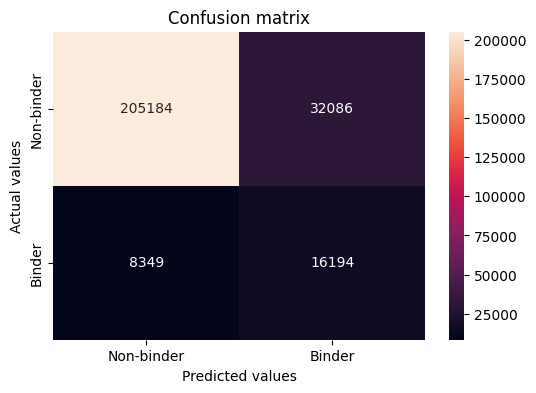

Accuracy score  :  0.8455577072185109
Sensitivity (TPR):  0.6598215377093265
Specificity (TNR):  0.864770093142833
AUC :  0.7690993986501794


In [22]:
model_rf = lst_tunning_models[0][1]

y_rf_test_proba = model_rf.predict_proba(pX_test_rf_case1)
df_test_rf = pd.DataFrame(data = y_rf_test_proba, columns = ["tmp", "predict_proba"])

df_test_rf = df_test_rf[["predict_proba"]]
df_prob_test_rf = pd.concat([test_trb_case3_cb_60, df_test_rf], axis=1)
df_prob_test_rf['binder_pred'] = np.where(df_prob_test_rf['predict_proba'] >= 0.5, 1, 0)

y_test02 = py_test_rf_case1["binder"].to_numpy()
y_test02_pred = df_prob_test_rf["binder_pred"].to_numpy()

confusionMatrix(y_test02, y_test02_pred)

tn02, fp02, fn02, tp02 = confusion_matrix(y_test02, y_test02_pred).ravel()
accuracy02 = float(accuracy_score(y_test02, y_test02_pred).ravel())
sensitivity02 = tp02/(tp02+fn02)
specificity02 = tn02/(tn02+fp02)
auc02 = metrics.roc_auc_score(y_test02, df_prob_test_rf["predict_proba"])
print ("Accuracy score  : ", accuracy02)
print('Sensitivity (TPR): ', sensitivity02)
print('Specificity (TNR): ', specificity02)
print ("AUC : ", auc02)

              precision    recall  f1-score   support

  Non-binder       0.95      0.84      0.89    263660
      Binder       0.08      0.23      0.12     16337

    accuracy                           0.80    279997
   macro avg       0.51      0.54      0.51    279997
weighted avg       0.90      0.80      0.85    279997



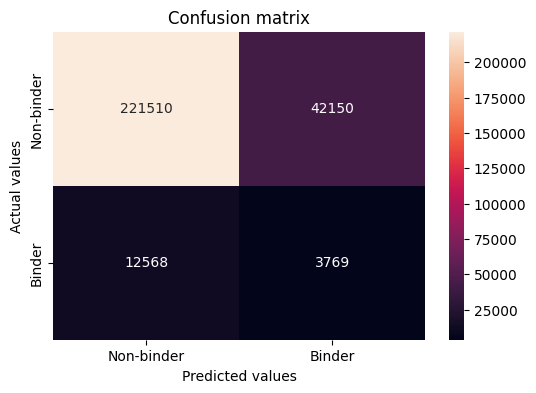

Accuracy score  :  0.8045764776051172
Sensitivity (TPR):  0.23070331150149967
Specificity (TNR):  0.8401350223773041
AUC :  0.7725006211500358


In [23]:
y_cb_test_proba = model_rf.predict_proba(pX_test_cb_case1)
df_test_cb = pd.DataFrame(data = y_cb_test_proba, columns = ["tmp", "predict_proba"])

df_test_cb = df_test_cb[["predict_proba"]]
df_prob_test_cb = pd.concat([test_trb, df_test_cb], axis=1)
df_prob_test_cb['binder_pred'] = np.where(df_prob_test_cb['predict_proba'] >= 0.5, 1, 0)

y_test02 = py_test_cb_case1["binder"].to_numpy()
y_test02_pred = df_prob_test_cb["binder_pred"].to_numpy()

confusionMatrix(y_test02, y_test02_pred)

tn02, fp02, fn02, tp02 = confusion_matrix(y_test02, y_test02_pred).ravel()
accuracy02 = float(accuracy_score(y_test02, y_test02_pred).ravel())
sensitivity02 = tp02/(tp02+fn02)
specificity02 = tn02/(tn02+fp02)
auc02 = metrics.roc_auc_score(y_test02, df_prob_test_cb["predict_proba"])
print ("Accuracy score  : ", accuracy02)
print('Sensitivity (TPR): ', sensitivity02)
print('Specificity (TNR): ', specificity02)
print ("AUC : ", auc02)

              precision    recall  f1-score   support

  Non-binder       0.99      0.49      0.65      5297
      Binder       0.02      0.60      0.04        84

    accuracy                           0.49      5381
   macro avg       0.50      0.54      0.34      5381
weighted avg       0.97      0.49      0.64      5381



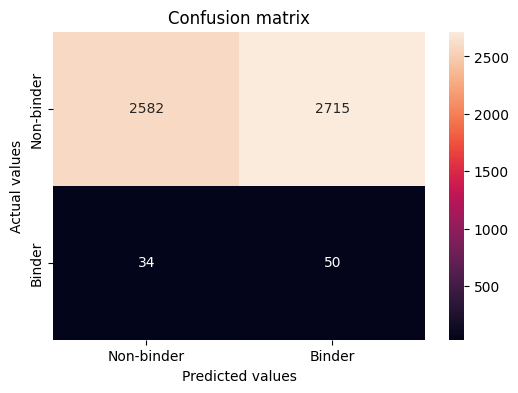

Accuracy score  :  0.48912841479278946
Sensitivity (TPR):  0.5952380952380952
Specificity (TNR):  0.487445723994714
AUC :  0.6176957756861476


In [24]:
y_test_proba_paper = model_rf.predict_proba(pX_test_paper)
df_test_paper = pd.DataFrame(data = y_test_proba_paper, columns = ["tmp", "predict_proba"])

df_test_paper = df_test_paper[["predict_proba"]]
df_prob_test_paper = pd.concat([test_paper_case1_exc_epi, df_test_paper], axis=1)
df_prob_test_paper['binder_pred'] = np.where(df_prob_test_paper['predict_proba'] >= 0.5, 1, 0)

y_test02 = py_test_paper["binder"].to_numpy()
y_test02_pred = df_prob_test_paper["binder_pred"].to_numpy()

confusionMatrix(y_test02, y_test02_pred)

tn02, fp02, fn02, tp02 = confusion_matrix(y_test02, y_test02_pred).ravel()
accuracy02 = float(accuracy_score(y_test02, y_test02_pred).ravel())
sensitivity02 = tp02/(tp02+fn02)
specificity02 = tn02/(tn02+fp02)
auc02 = metrics.roc_auc_score(y_test02, df_prob_test_paper["predict_proba"])
print ("Accuracy score  : ", accuracy02)
print('Sensitivity (TPR): ', sensitivity02)
print('Specificity (TNR): ', specificity02)
print ("AUC : ", auc02)

## NetTCR

              precision    recall  f1-score   support

  Non-binder       0.99      0.99      0.99    699070
      Binder       0.91      0.86      0.89     60335

    accuracy                           0.98    759405
   macro avg       0.95      0.93      0.94    759405
weighted avg       0.98      0.98      0.98    759405



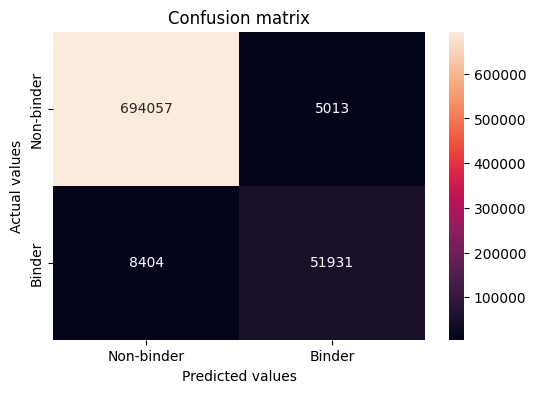

Accuracy score  :  0.9823322206200907
Sensitivity (TPR):  0.860711030082042
Specificity (TNR):  0.9928290443017151
AUC :  0.9960440646470455


In [25]:
out_ptest_rf_cnn = pd.read_csv("./data_final/output/test_trb_case3_cb_60_output.csv")
out_ptest_rf_cnn['binder_pred'] = np.where(out_ptest_rf_cnn['prediction'] >= 0.5, 1, 0)

y_test = out_ptest_rf_cnn["binder"].to_numpy()
y_test_pred = out_ptest_rf_cnn["binder_pred"].to_numpy()

confusionMatrix(y_test, y_test_pred)

tn, fp, fn, tp= confusion_matrix(y_test, y_test_pred).ravel()
accuracy = float(accuracy_score(y_test, y_test_pred).ravel())
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
auc = metrics.roc_auc_score(y_test, out_ptest_rf_cnn["prediction"])
print ("Accuracy score  : ", accuracy)
print('Sensitivity (TPR): ', sensitivity)
print('Specificity (TNR): ', specificity)
print ("AUC : ", auc)

              precision    recall  f1-score   support

  Non-binder       0.94      0.69      0.80    263660
      Binder       0.06      0.31      0.10     16337

    accuracy                           0.67    279997
   macro avg       0.50      0.50      0.45    279997
weighted avg       0.89      0.67      0.76    279997



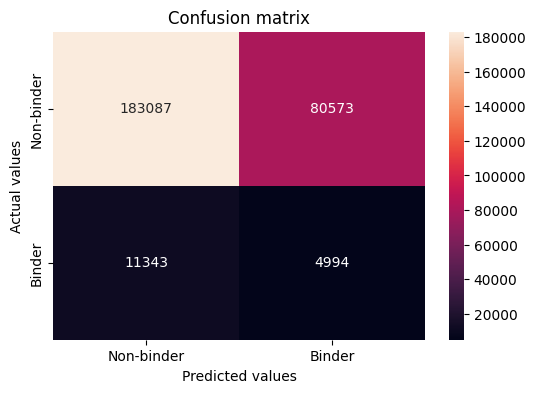

Accuracy score  :  0.6717250541970092
Sensitivity (TPR):  0.30568647854563263
Specificity (TNR):  0.6944056739740575
AUC :  0.5726182351217172


In [26]:
out_ptest_cb = pd.read_csv("./data_final/output/test_trb_case3_output.csv")
out_ptest_cb['binder_pred'] = np.where(out_ptest_cb['prediction'] >= 0.5, 1, 0)

y_test = out_ptest_cb["binder"].to_numpy()
y_test_pred = out_ptest_cb["binder_pred"].to_numpy()

confusionMatrix(y_test, y_test_pred)

tn, fp, fn, tp= confusion_matrix(y_test, y_test_pred).ravel()
accuracy = float(accuracy_score(y_test, y_test_pred).ravel())
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
auc = metrics.roc_auc_score(y_test, out_ptest_cb["prediction"])
print ("Accuracy score  : ", accuracy)
print('Sensitivity (TPR): ', sensitivity)
print('Specificity (TNR): ', specificity)
print ("AUC : ", auc)

              precision    recall  f1-score   support

  Non-binder       0.99      0.40      0.57      5297
      Binder       0.02      0.70      0.04        84

    accuracy                           0.40      5381
   macro avg       0.50      0.55      0.30      5381
weighted avg       0.97      0.40      0.56      5381



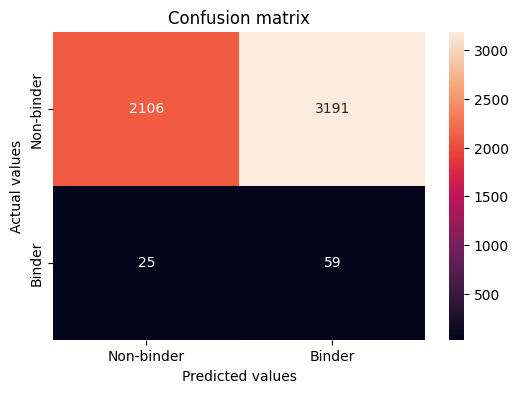

Accuracy score  :  0.4023415721984761
Sensitivity (TPR):  0.7023809523809523
Specificity (TNR):  0.3975835378516141
AUC :  0.5769191006589535


In [27]:
out_ptest_cnn_paper = pd.read_csv("./data_final/output/test_paper_case3_exc_epi_output.csv")
out_ptest_cnn_paper['binder_pred'] = np.where(out_ptest_cnn_paper['prediction'] >= 0.5, 1, 0)

y_test = out_ptest_cnn_paper["binder"].to_numpy()
y_test_pred = out_ptest_cnn_paper["binder_pred"].to_numpy()

confusionMatrix(y_test, y_test_pred)

tn, fp, fn, tp= confusion_matrix(y_test, y_test_pred).ravel()
accuracy = float(accuracy_score(y_test, y_test_pred).ravel())
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
auc = metrics.roc_auc_score(y_test, out_ptest_cnn_paper["prediction"])
print ("Accuracy score  : ", accuracy)
print('Sensitivity (TPR): ', sensitivity)
print('Specificity (TNR): ', specificity)
print ("AUC : ", auc)

## CB

In [28]:
pdata_cb_train = pd.concat([out_ptest_rf_cnn[["prediction"]], df_prob_test_rf[["predict_proba"]]], axis=1)
pdata_cb_train = pdata_cb_train.rename(columns={"predict_proba":"rf_proba", "prediction":"cnn_proba"})

pdata_cb_test = pd.concat([out_ptest_cb[["prediction"]], df_prob_test_cb[["predict_proba"]]], axis=1)
pdata_cb_test = pdata_cb_test.rename(columns={"predict_proba":"rf_proba", "prediction":"cnn_proba"})

pdata_test_paper = pd.concat([out_ptest_cnn_paper[["prediction"]], df_prob_test_paper[["predict_proba"]]], axis=1)
pdata_test_paper = pdata_test_paper.rename(columns={"predict_proba":"rf_proba", "prediction":"cnn_proba"})

In [29]:
X_data = pdata_cb_train.copy()
y_data = out_ptest_rf_cnn[["binder"]]

X_data_test = pdata_cb_test.copy()
y_data_test = out_ptest_cb[["binder"]]

X_data_test_paper = pdata_test_paper.copy()
y_data_test_paper = out_ptest_cnn_paper[["binder"]]

In [30]:
model_base = CatBoostClassifier(iterations=1000, learning_rate=1, depth=2)
model_base.fit(X_data, y_data, verbose=False)

In [31]:
y_test_cb = model_base.predict_proba(X_data_test)
df_cb = pd.DataFrame(data = y_test_cb, columns = ["tmp", "predict_proba"])
df_cb = df_cb[["predict_proba"]]

df_cb_prob = pd.concat([out_ptest_cb[["CDR3b", "epitope", "binder"]], df_cb], axis=1)
df_cb_prob['binder_pred'] = np.where(df_cb_prob['predict_proba'] >= 0.5, 1, 0)
df_cb_prob

,CDR3b,epitope,binder,predict_proba,binder_pred
0,ASSKRSTDTQY,LVTCLGLSY,0,9.799279e-01,1
1,SARDLETSGGLETQY,LSETFQLLI,0,4.820367e-08,0
2,ASSPPNSYEQY,LLLAHIIAL,0,4.820367e-08,0
3,ASSPTGQGAHGYT,HVYVGNISK,0,3.215623e-05,0
4,ASSGGGLPLSSGNTIY,HSALLALRY,0,4.820367e-08,0
...,...,...,...,...,...
279992,ASYNFGQYGYT,RAFSPEVIPMF,1,4.820367e-08,0
279993,ASSLRDGYTGEL,HISINLPKRI,1,2.712724e-01,0
279994,ASSLRDGYTGEL,WIHWNIPKRI,1,2.712724e-01,0
279995,ASSPSASVNNEQF,YSEHPTFTSQY,1,4.820367e-08,0


              precision    recall  f1-score   support

  Non-binder       0.94      0.84      0.89    263660
      Binder       0.04      0.11      0.06     16337

    accuracy                           0.80    279997
   macro avg       0.49      0.47      0.47    279997
weighted avg       0.89      0.80      0.84    279997



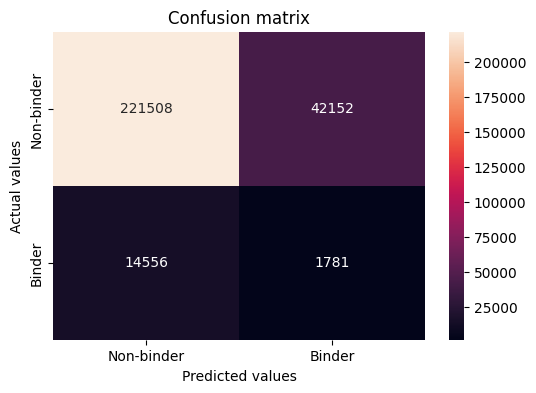

Accuracy score  :  0.7974692585991993
Sensitivity (TPR):  0.10901634326987819
Specificity (TNR):  0.8401274368504893
AUC :  0.5352848230899555


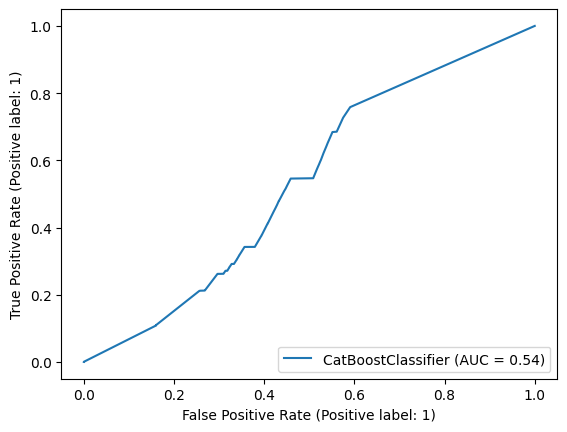

In [40]:
y_test02 = df_cb_prob["binder"].to_numpy()
y_test02_pred = df_cb_prob["binder_pred"].to_numpy()

confusionMatrix(y_test02, y_test02_pred)

tn02, fp02, fn02, tp02 = confusion_matrix(y_test02, y_test02_pred).ravel()
accuracy02 = float(accuracy_score(y_test02, y_test02_pred).ravel())
sensitivity02 = tp02/(tp02+fn02)
specificity02 = tn02/(tn02+fp02)
auc02 = metrics.roc_auc_score(y_test02, df_cb_prob["predict_proba"])
print ("Accuracy score  : ", accuracy02)
print('Sensitivity (TPR): ', sensitivity02)
print('Specificity (TNR): ', specificity02)
print ("AUC : ", auc02)

rocAuc(model_base, X_data_test, y_test02)

In [33]:
y_test_cb = model_base.predict_proba(X_data_test_paper)
df_cb = pd.DataFrame(data = y_test_cb, columns = ["tmp", "predict_proba"])
df_cb = df_cb[["predict_proba"]]

df_prob_paper = pd.concat([out_ptest_cnn_paper[["CDR3b", "epitope", "binder"]], df_cb], axis=1)
df_prob_paper['binder_pred'] = np.where(df_prob_paper['predict_proba'] >= 0.5, 1, 0)
df_prob_paper

,CDR3b,epitope,binder,predict_proba,binder_pred
0,ASRPGQVVYGYT,LLAIKVPNV,0,9.799279e-01,1
1,ASRPGQVVYGYT,LIIPFIHLI,0,4.820367e-08,0
2,ASRPGQVVYGYT,VLFHRAFLV,0,9.799279e-01,1
3,ASRPGQVVYGYT,FLIYLDVSV,0,2.428734e-06,0
4,ASRPGQVVYGYT,KMVAVFYNT,0,2.712724e-01,0
...,...,...,...,...,...
5376,ASGGTGEYEQY,FMIGYTSAL,1,9.799279e-01,1
5377,ASSGSSVETQY,LIIPFIHLI,1,2.369083e-05,0
5378,ASSGGGGRGYNEQF,LIIPFIHLI,1,1.884967e-03,0
5379,ASSEGLGWEQF,FLIYLDVSV,1,5.635668e-05,0


In [34]:
df_prob_paper.binder_pred.value_counts()

0    3361
1    2020
Name: binder_pred, dtype: int64

              precision    recall  f1-score   support

  Non-binder       0.99      0.63      0.77      5297
      Binder       0.02      0.51      0.04        84

    accuracy                           0.62      5381
   macro avg       0.50      0.57      0.40      5381
weighted avg       0.97      0.62      0.76      5381



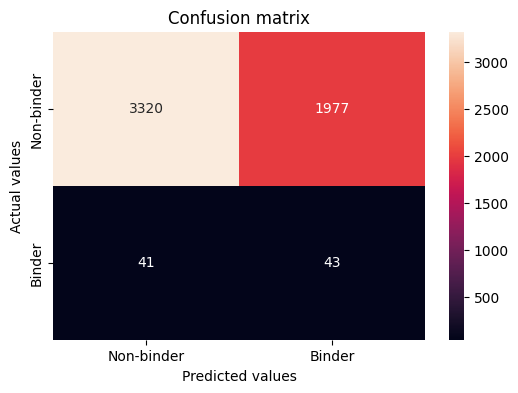

Accuracy score  :  0.6249767701170786
Sensitivity (TPR):  0.5119047619047619
Specificity (TNR):  0.6267698697375873
AUC :  0.5800475561189173


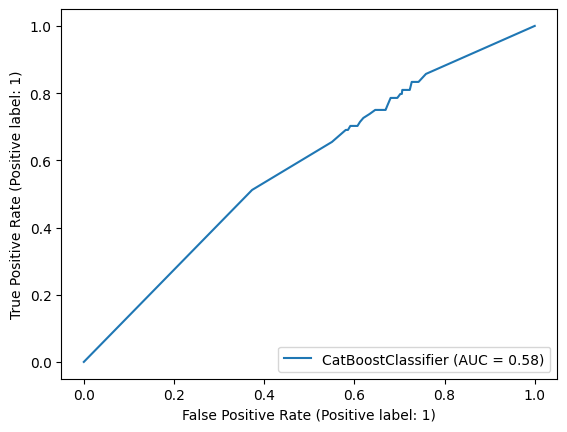

In [37]:
y_test02 = df_prob_paper["binder"].to_numpy()
y_test02_pred = df_prob_paper["binder_pred"].to_numpy()

confusionMatrix(y_test02, y_test02_pred)

tn02, fp02, fn02, tp02 = confusion_matrix(y_test02, y_test02_pred).ravel()
accuracy02 = float(accuracy_score(y_test02, y_test02_pred).ravel())
sensitivity02 = tp02/(tp02+fn02)
specificity02 = tn02/(tn02+fp02)
auc02 = metrics.roc_auc_score(y_test02, df_prob_paper["predict_proba"])
print ("Accuracy score  : ", accuracy02)
print('Sensitivity (TPR): ', sensitivity02)
print('Specificity (TNR): ', specificity02)
print ("AUC : ", auc02)

rocAuc(model_base, X_data_test_paper, y_test02)

In [36]:
def rocAuc(model, X, y_true):
    plot_roc_curve(model, X, y_true)
    plt.show()